In [86]:
import numpy as np
import scipy as sp
import scipy.io
from scipy.stats import unitary_group
from datetime import datetime
import matplotlib.pyplot as plt
import qutip as qt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product, combinations
from joblib import Parallel, delayed
import glob
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import photon as ph
from functools import reduce
from cvxopt import matrix, solvers
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading in data from .mat and .txt file

In [192]:
# Loading in the QST calibration states data.

is_math_file = True
if is_math_file:
    
    path  = "Photon_REM/photonic QREM experimental data v3/calibration states/*"
    mat_files = glob.glob(path)[::-1] # To get order HVVH, HLVR, HDVA
    print(mat_files)
    #mat_files = [glob.glob(p + "/*.mat")[0] for p in paths]

    # Load from math files
    QST_dic = [sp.io.loadmat(f) for f in mat_files]
    #print(QST_coinc_count_dic)
    QST_coinc_keys = [list(mat.keys())[6] for mat in QST_dic]
    QST_calib_keys = [list(mat.keys())[3] for mat in QST_dic]
    #print(QST_coinc_keys)
    QST_coinc_counts = np.array([mat[key].T[0] for mat, key in zip(QST_dic, QST_coinc_keys)])
    
    print(QST_coinc_counts)
    
    # Load reconstructed density matrices
    #qst_path = "Photon_REM/photonic QREM experimental data v3/calibration states/hvvh/hvvh_rho.mat"
    #calib_rho_dict = sp.io.loadmat(qst_path)
    calib_rhos_exp = np.array([mat[key] for mat, key in zip(QST_dic, QST_calib_keys)])
    print(calib_rhos_exp)

    # Load the QDT coincidence counts
    qdt_path_ideal = 'Photon_REM/photonic QREM experimental data v3/10 detTomo no lens/detTomo_nolens.mat'
    qdt_path_lens = "Photon_REM/photonic QREM experimental data v3/detector tomography/detTomo_lens.mat"
    #"Photon_REM/photonic QREM experimental data v3/detector tomography/detTomo_lens.mat"
    qdt_conc_dict_ideal = sp.io.loadmat(qdt_path_ideal)
    QDT_conts_ideal = qdt_conc_dict_ideal['detTomo_noLens_coincRaw'].T[0]
    
    qdt_conc_dict_lens = sp.io.loadmat(qdt_path_lens)
    QDT_conts_lens = qdt_conc_dict_lens['detTomo_lens_coincRaw'].T[0]
    
   # print(QDT_conts)

else: # Is .txt
    path  = "Photon_REM/photonic QREM experimental data v2/calibration states/*coinc.txt"
    paths = glob.glob(path)
    print(paths)
    QST_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])[::-1]
    print(QST_coinc_counts)

    # Load reconstructed density matrices
    qst_path = glob.glob("Photon_REM/photonic QREM experimental data v2/calibration states/*rho.txt")
    # Read the file content
    with open(qst_path[0], 'r') as file:
        lines = file.readlines()
    #print(lines)
    # Initialize a list to store the complex matrix
    complex_matrix = []

    # Parse each line
    for line in lines:
        if line.strip() and '=' not in line:  # Ignore empty lines and the definition line
            # Replace i with j to make it compatible with Python's complex numbers
            formatted_line = line.replace('i', 'j').strip()
            # Split the line by spaces to extract each complex number
            row = [complex(num) for num in formatted_line.split()]
            complex_matrix.append(row)
            
    # Convert the list to a NumPy array
    calib_rho = np.array(complex_matrix)
    # Detector tomography coincidence counts
    qdt_path = "Photon_REM/photonic QREM experimental data v2/detector tomography/detTomo_coinc.txt"
    QDT_conts = np.loadtxt(qdt_path, skiprows=2)
    print(QDT_conts)

['Photon_REM/photonic QREM experimental data v3/calibration states\\HVVH.mat', 'Photon_REM/photonic QREM experimental data v3/calibration states\\HLVR.mat', 'Photon_REM/photonic QREM experimental data v3/calibration states\\HDVA.mat']
[[ 3177 65450  2662 66047 37368 30898 34380 32751 38443 64459 29611 32560
  34920 45655 23097  3524]
 [34397 36707 31705 34584 33792 34055  2847 65434 29402 35483 66202 49133
  20573  4338 66699 28316]
 [32510 37309 32158 36963 30337 37616  3065 65758 37667 36421 27737 66357
   4286 49185 21812  3751]]
[[[ 0.01+0.j   -0.01-0.06j -0.01-0.04j -0.  -0.j  ]
  [-0.01+0.06j  0.48+0.j    0.46+0.06j  0.  +0.04j]
  [-0.01+0.04j  0.46-0.06j  0.49+0.j    0.01+0.06j]
  [-0.  +0.j    0.  -0.04j  0.01-0.06j  0.01+0.j  ]]

 [[ 0.25+0.j    0.09+0.24j  0.23-0.j   -0.06-0.21j]
  [ 0.09-0.24j  0.27+0.j    0.08-0.24j -0.24-0.01j]
  [ 0.23+0.j    0.08+0.24j  0.25+0.j   -0.08-0.21j]
  [-0.06+0.21j -0.24+0.01j -0.08+0.21j  0.23+0.j  ]]

 [[ 0.23+0.j    0.23-0.09j  0.23+0.02j -0

In [193]:
path_lens  = "Photon_REM/photonic QREM experimental data v3/13 HVVH with lens/HVVH_lens.mat"
path_no_lens = "Photon_REM/photonic QREM experimental data v3/01 HVVH no lens/HVVH.mat"

lens_dict = sp.io.loadmat(path_lens)
no_lens_dict = sp.io.loadmat(path_no_lens)
hvvh_lens = lens_dict['HVVH_lens_coincRaw'].T[0]
hvvh_no_lens = no_lens_dict['HVVH_coincRaw'].T[0]

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']

print(coincidene_order_QST)
print(hvvh_lens)
print(hvvh_no_lens)
print(hvvh_lens/hvvh_no_lens)

['HH', 'HV', 'VV', 'VH', 'RH', 'RV', 'DV', 'DH', 'DR', 'DD', 'RD', 'HD', 'VD', 'VL', 'HL', 'RL']
[ 1208 44567  1029 15002  8811 23029 23426  8489 24248 25508  8598 22071
  9303 10581 17651  4829]
[ 3177 65450  2662 66047 37368 30898 34380 32751 38443 64459 29611 32560
 34920 45655 23097  3524]
[0.38 0.68 0.39 0.23 0.24 0.75 0.68 0.26 0.63 0.4  0.29 0.68 0.27 0.23
 0.76 1.37]


### Reconstructing the calibration states from coincidences 

[[13.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 13.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j 13.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 13.+0.j]]
[[13.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 13.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j 13.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 13.+0.j]]
[[13.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 13.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j 13.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 13.+0.j]]
Exp reconstruction


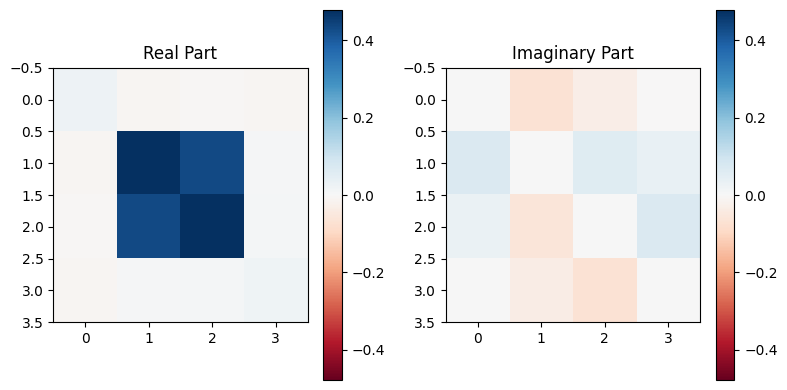

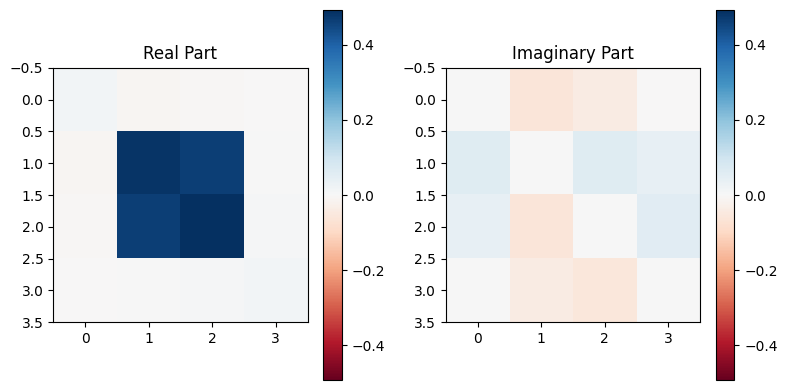

Ideal state


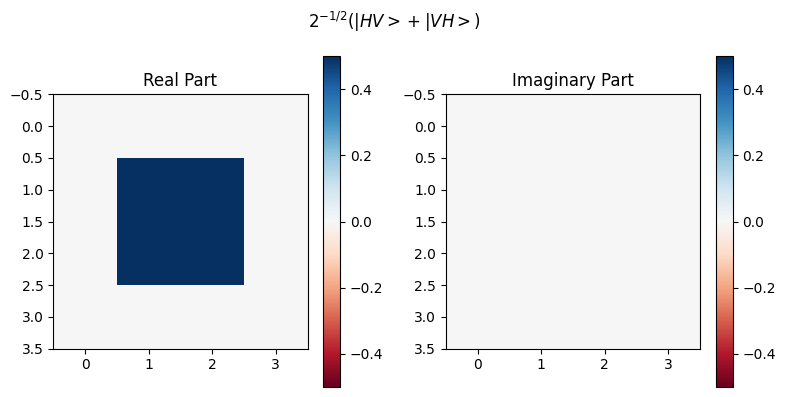

Exp reconstruction


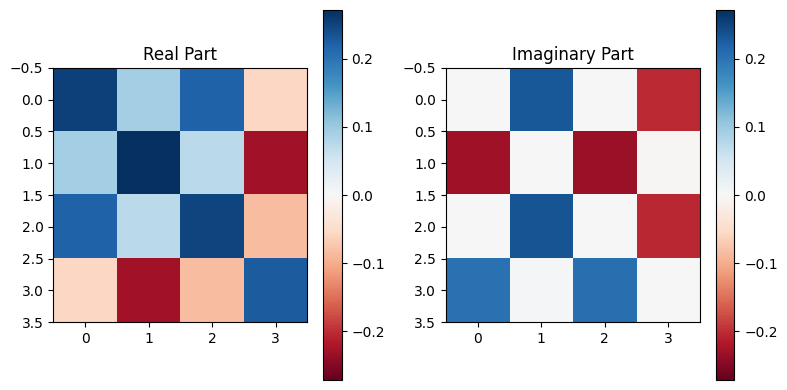

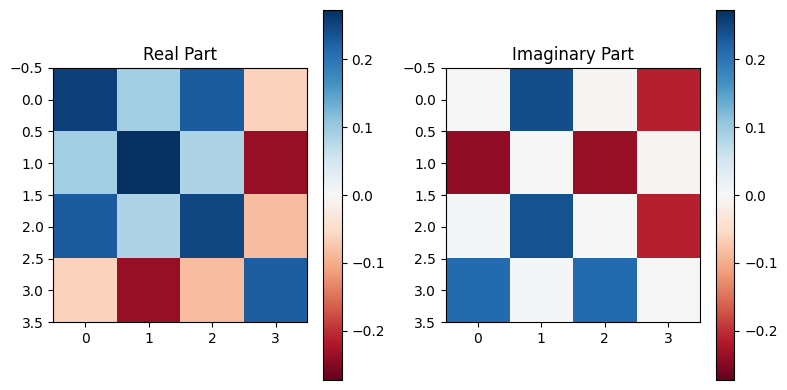

Ideal state


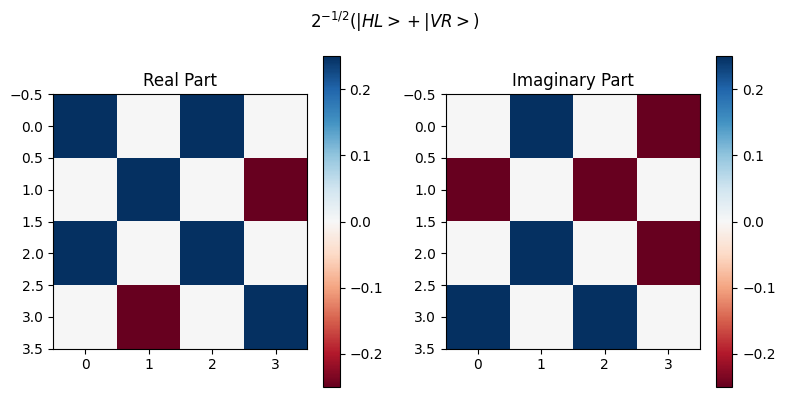

Exp reconstruction


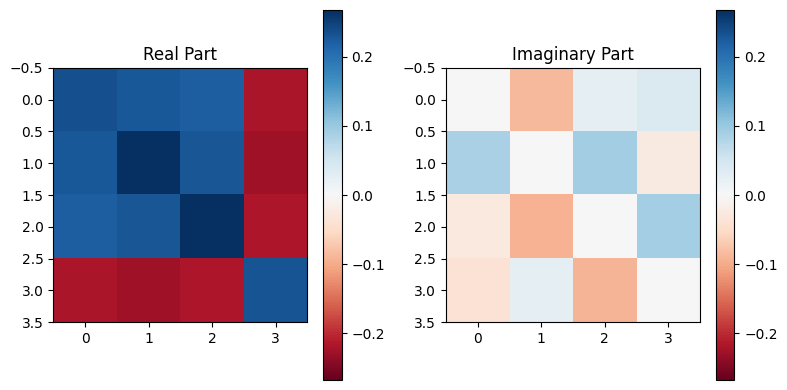

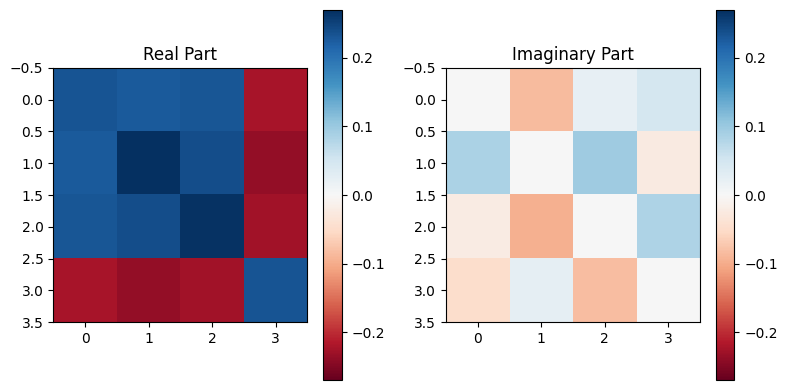

Ideal state


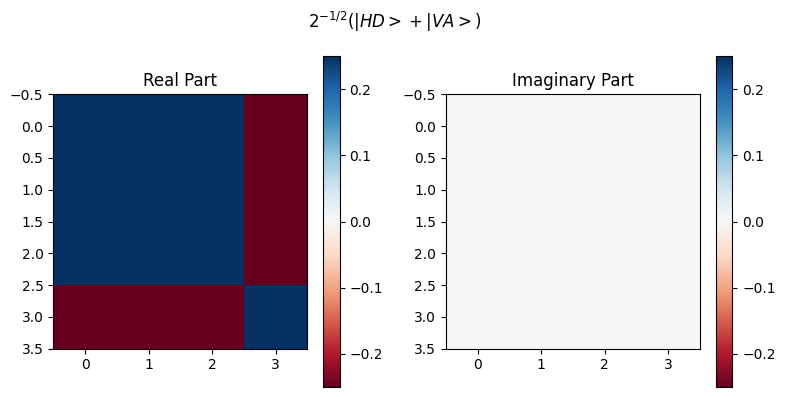

[[ 3177 65450  2662 66047 37368 30898 34380 32751 38443 64459 29611 32560
  34920 45655 23097  3524]
 [34397 36707 31705 34584 33792 34055  2847 65434 29402 35483 66202 49133
  20573  4338 66699 28316]
 [32510 37309 32158 36963 30337 37616  3065 65758 37667 36421 27737 66357
   4286 49185 21812  3751]]
[[  3177  65450   5324 132094  37368  30898  34380  32751  38443  64459
   29611  32560  69840  91310  23097   3524]
 [ 34397  36707  63410  69168  33792  34055   2847  65434  29402  35483
   66202  49133  41146   8676  66699  28316]
 [ 32510  37309  64316  73926  30337  37616   3065  65758  37667  36421
   27737  66357   8572  98370  21812   3751]]


In [226]:
# Define the eigenstates
plus_x = np.array([1, 1]) / np.sqrt(2)
minus_x = np.array([1, -1]) / np.sqrt(2)

plus_y = np.array([1, 1j]) / np.sqrt(2)
minus_y = np.array([1, -1j]) / np.sqrt(2)

plus_z = np.array([1, 0])
minus_z = np.array([0, 1])

# Define density matrices
xup = np.outer(plus_x, np.conj(plus_x)) # D
xdown = np.outer(minus_x, np.conj(minus_x)) # A

yup = np.outer(plus_y, np.conj(plus_y)) # R
ydown = np.outer(minus_y, np.conj(minus_y)) # L

zup = np.outer(plus_z, np.conj(plus_z)) # H
zdown = np.outer(minus_z, np.conj(minus_z)) # V

# Create the ideal calibration states
# [HV + VH, HL + VR, HD + VA]
ideal_calib_states = 1/np.sqrt(2) * np.array([np.kron(plus_z,minus_z) + np.kron(minus_z,plus_z),
                                              np.kron(plus_z,minus_y) + np.kron(minus_z, plus_y),
                                              np.kron(plus_z,plus_x) + np.kron(minus_z,minus_x)
                                              ])
ideal_calib_rho = np.array([np.outer(state,np.conj(state)) for state in ideal_calib_states])

# Create operator count order 
coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']


QST_op_order = ph.photon_label_to_operator(coincidene_order_QST)

title_lables = np.array([r'$2^{-1/2}(|HV>+|VH>)$',r'$2^{-1/2}(|HL>+|VR>)$', r'$2^{-1/2}(|HD>+|VA>)$'])
# Reconstruct the 2 qubit calibration states
rho_list = [ph.coincidence_to_states(mat, QST_op_order) for mat in QST_coinc_counts]
# Compare to the ideal ones.
for rho, rho_ideal, title, calib_rhos in zip(rho_list,ideal_calib_rho, title_lables, calib_rhos_exp):
    print('Exp reconstruction')
    vis.visualize_state(rho)
    vis.visualize_state(calib_rhos)
    print('Ideal state')
    vis.visualize_state(rho_ideal, title = title )

#vis.visualize_state(calib_rho)
    
    
print(QST_coinc_counts)
mult_vector = np.array([1,1,2,2,1,1,1,1,1,1,1,1,2,2,1,1])

print(np.einsum('i,ji->ji',mult_vector, QST_coinc_counts))
    
# Save ideal matrix for experimental comparison    
# N_shots = 1000
# print(ideal_calib_rho)
# outcomes = ph.simulate_photon_coincidence_counts(N_shots, ideal_calib_rho, QST_op_order)
# print(outcomes)

# matrix_dict = {"HVVH": ideal_calib_rho[0], 
#                "HLVR": ideal_calib_rho[1], 
#                "HDVA": ideal_calib_rho[2]}
# coinc_dict = {"order": coincidene_order_QST,
#               "Total_orhtogonal_coinc": N_shots,
#               "HVVH_coinc": outcomes[0],
#               "HLVR_coinc": outcomes[1],
#               "HDVA_coinc": outcomes[2]}

#scipy.io.savemat('Photon_REM/deal_calibration_matrices.mat', matrix_dict)
#scipy.io.savemat('Photon_REM/ideal_calibration_coinc.mat', coinc_dict)
#test = sp.io.loadmat('Photon_REM/ideal_calibration_matrices.mat') 
#test_2 = sp.io.loadmat('Photon_REM/ideal_calibration_coinc.mat')


Create the calibration states in two ways
1) From the 2 qubit reconstructions project onto ideal A channel projector and trace donw
2) Postselect 1 qubit data from the 2 qubit qst and reconstuct only B channel state

In [195]:
# Trace out herald states. 
# To do this we need to first know which states was measured by the Harald.
# 1) Project ideal harald projector on the reconstructed state.  
# 2) Trace out the harald qubit, givng the calibration state. 

# Creating the protocol calibration states
state_index_list = [0,0,1,2,1,2]
herald_projector_lables = ['H','V','H', 'H', 'V', 'V']
projector_list = ph.photon_label_to_operator(herald_projector_lables)
reshaped_states = np.array(rho_list).reshape(3,2,2,2,2)

# Apply projectors to the calibration states
projected_rho_list = np.array( [np.einsum('ij,jk,kl->il' , np.kron(proj,np.eye(2)), calib_rhos_exp[rho_index], np.kron(proj,np.eye(2)) ) for rho_index, proj in zip(state_index_list, projector_list)])

# Renormalize the states
normalized_projected_rho_list = np.array([rho/np.trace(rho) for rho in projected_rho_list])
# Trace down
reshaped_states = normalized_projected_rho_list.reshape(6,2,2,2,2)
traced_down_calib_states = np.einsum('nijik -> njk', reshaped_states)
ideal_labels = ['V','H','L', 'D', 'R', 'A']
ideal_calibration_states = ph.photon_label_to_operator(ideal_labels)
# for state, ideal_state in zip(traced_down_calib_states,ideal_calibration_states):
    # vis.visualize_state(state)
    # vis.visualize_state(ideal_state)
    
    #print(np.trace(state))
    #print(np.trace(state@state))

# Directly reconstruct one qubit states.
# Select the proper samples # order HVDL
sample_index = np.array([[0,1,11,14],
                         [3,2,12,13]])

# Create operator count order 
# coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
#                         'RH', 'RV', 'DV', 'DH',
#                         'DR', 'DD', 'RD', 'HD',
#                         'VD', 'VL', 'HL', 'RL']
one_qubit_labels = ['H','V','D','L']	
one_qubit_projectors = ph.photon_label_to_operator(one_qubit_labels)

one_qubit_states = np.array([ph.coincidence_to_states(QST_coinc_counts[i,index],one_qubit_projectors,1) for i in range(len(QST_coinc_counts)) for index in sample_index ])
# Reoderd to match protocol calibration states
one_qubit_states = one_qubit_states[[0,1,2,4,3,5]]
print("Compare the two calibration states")
one_qubit_state_labels = ['H','V','L','D', 'R', "A"]
for i in range(len(one_qubit_states)):
    # vis.visualize_state(one_qubit_states[i])
    # vis.visualize_state(traced_down_calib_states[i])
   # print(f'Difference between 1) and 2) for {one_qubit_state_labels[i]}: {sf.qubit_infidelity(one_qubit_states[i],traced_down_calib_states[i])}')
    print(f'Difference between 1) and ideal for {one_qubit_state_labels[i]}: {sf.qubit_infidelity(traced_down_calib_states[i],ideal_calibration_states[i])}')
    #print(f'Difference between 2) and ideal for {one_qubit_state_labels[i]}: {sf.qubit_infidelity(one_qubit_states[i],ideal_calibration_states[i])}')

Compare the two calibration states
Difference between 1) and ideal for H: 0.025067903600658026
Difference between 1) and ideal for V: 0.023356370883789168
Difference between 1) and ideal for L: 0.041658024483347544
Difference between 1) and ideal for D: 0.04732130530183809
Difference between 1) and ideal for R: 0.05023596078722159
Difference between 1) and ideal for A: 0.045462132321507864


### QDT reconstruct the POVM with lense 

In [196]:
print(QDT_conts_lens.reshape((6,6)))
print(QDT_conts_ideal.reshape((6,6)))
print( QDT_conts_lens.reshape((6,6))/QDT_conts_ideal.reshape((6,6)))
#print(QDT_conts_ideal.reshape((6,6)) - QDT_conts_lens.reshape((6,6)))
# mult_array = np.array([1,3,1,1,3,3])
# new_QDT_counts_lens = np.einsum("i,ij->ij",mult_array, QDT_conts_lens.reshape((6,6)))
# print(new_QDT_counts_lens)
QDT_conts_ideal = QDT_conts_ideal.reshape((6,6))
QDT_conts_lens = QDT_conts_lens.reshape((6,6))
print(QDT_conts_ideal[:,0]/QDT_conts_ideal[:,1])
print(QDT_conts_lens[:,0]/QDT_conts_lens[:,1])

[[ 1129 43412 17460 26818 21580 22739]
 [13311  1011  9453  4859  8360  6226]
 [21431 21732 41648  1712 28051 17885]
 [20774 22659 15372 28197 41829  1142]
 [ 7631  5546  1398 11717  4095  8709]
 [ 8343  5504  9724  4235  1378 12767]]
[[ 3324 65461 23251 44474 32465 35121]
 [74341  2805 51167 26572 39636 38123]
 [34569 37432 66778  4869 49125 26165]
 [32478 38160 21965 49399 65798  3429]
 [39022 34904  4513 69410 23360 47125]
 [40701 34835 53129 23191  4253 72286]]
[[0.34 0.66 0.75 0.6  0.66 0.65]
 [0.18 0.36 0.18 0.18 0.21 0.16]
 [0.62 0.58 0.62 0.35 0.57 0.68]
 [0.64 0.59 0.7  0.57 0.64 0.33]
 [0.2  0.16 0.31 0.17 0.18 0.18]
 [0.2  0.16 0.18 0.18 0.32 0.18]]
[ 0.05 26.5   0.92  0.85  1.12  1.17]
[ 0.03 13.17  0.99  0.92  1.38  1.52]


[[ 3324 65461 23251 44474 32465 35121]
 [74341  2805 51167 26572 39636 38123]
 [34569 37432 66778  4869 49125 26165]
 [32478 38160 21965 49399 65798  3429]
 [39022 34904  4513 69410 23360 47125]
 [40701 34835 53129 23191  4253 72286]]
[[2.94 1.51 1.33 1.66 1.5  1.54]
 [5.58 2.77 5.41 5.47 4.74 6.12]
 [1.61 1.72 1.6  2.84 1.75 1.46]
 [1.56 1.68 1.43 1.75 1.57 3.  ]
 [5.11 6.29 3.23 5.92 5.7  5.41]
 [4.88 6.33 5.46 5.48 3.09 5.66]]
[[ 3324 65461 23251 44474 32465 35121]
 [74341  2805 51167 26572 39636 38123]
 [34569 37432 66778  4869 49125 26165]
 [32478 38160 21965 49399 65798  3429]
 [39022 34904  4513 69410 23360 47125]
 [40701 34835 53129 23191  4253 72286]]
[[ 3324 65461]
 [74341  2805]
 [34569 37432]
 [32478 38160]
 [39022 34904]
 [40701 34835]]
[[23251 44474]
 [51167 26572]
 [66778  4869]
 [21965 49399]
 [ 4513 69410]
 [53129 23191]]
[[32465 35121]
 [39636 38123]
 [49125 26165]
 [65798  3429]
 [23360 47125]
 [ 4253 72286]]
	Number of MLE iterations: 50, final distance 8.0491169285

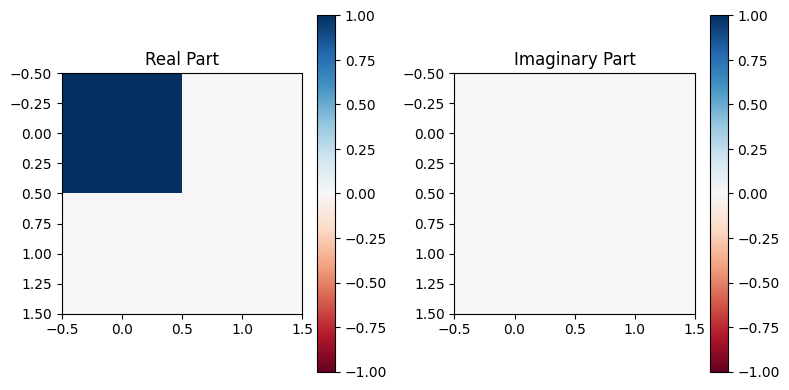

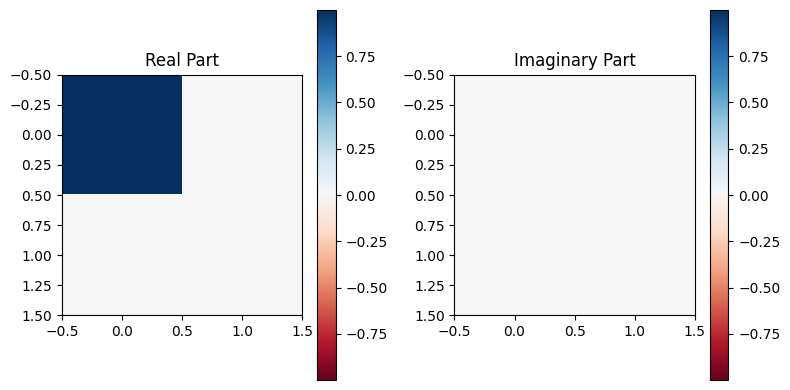

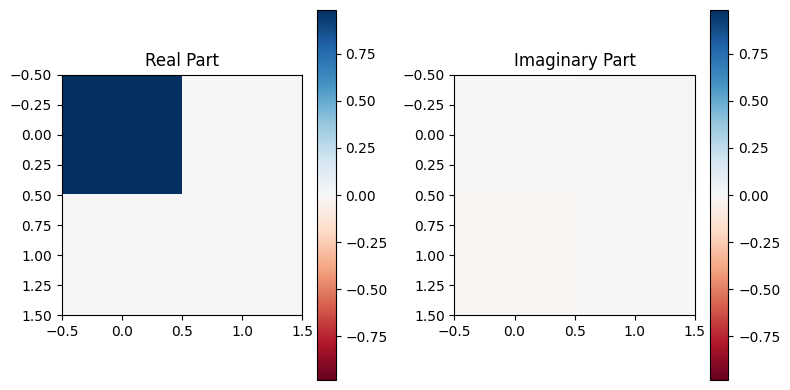

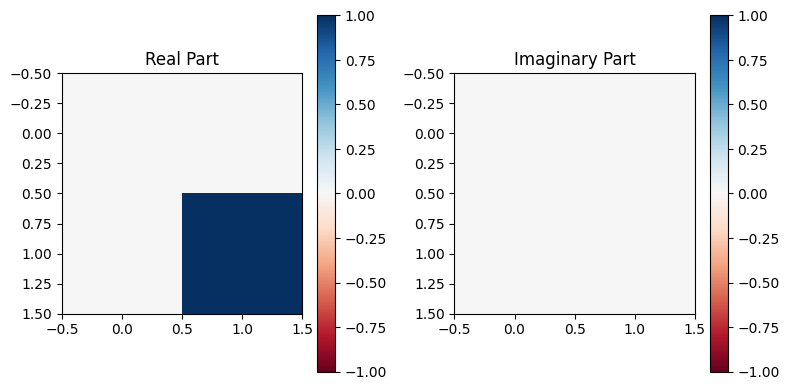

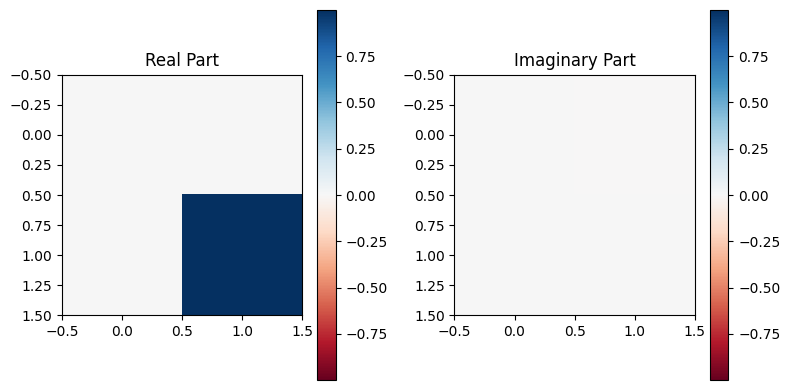

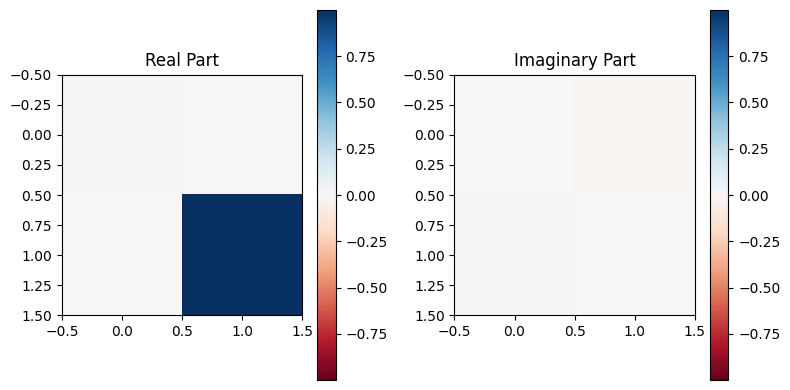

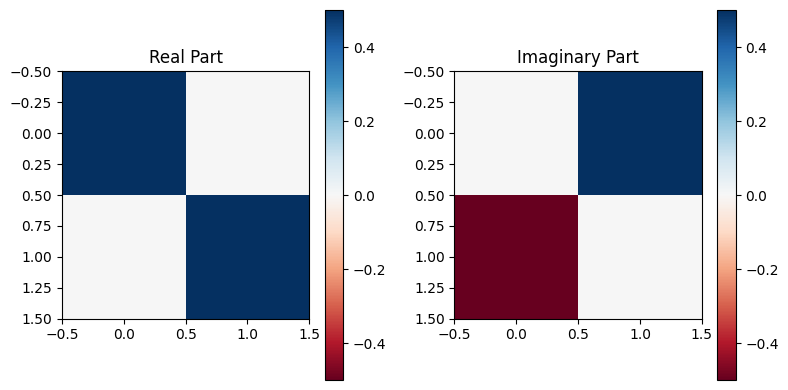

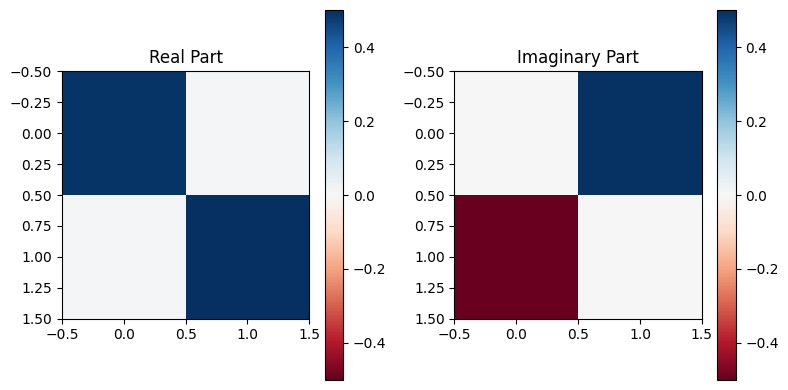

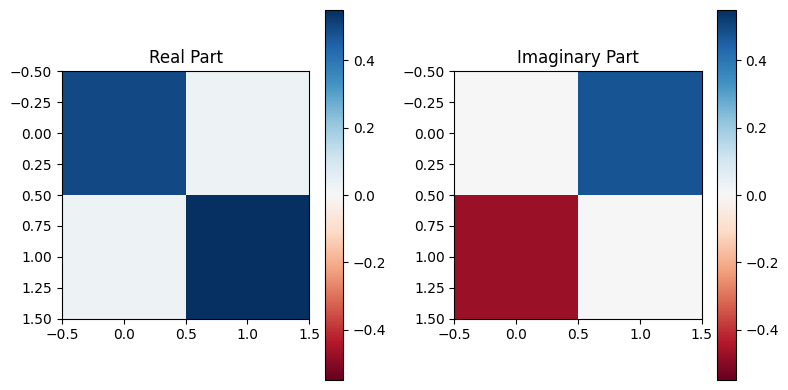

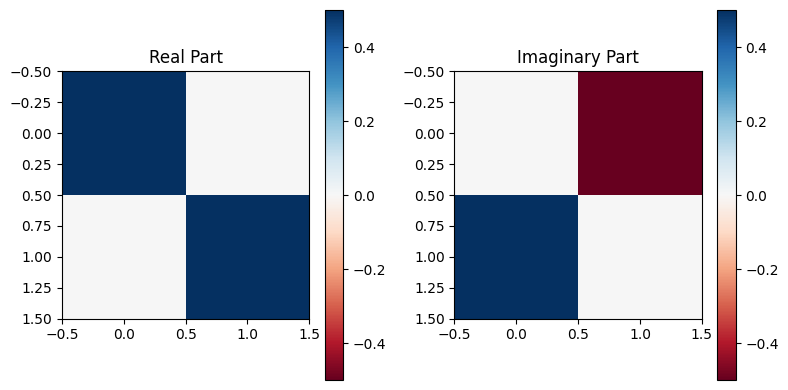

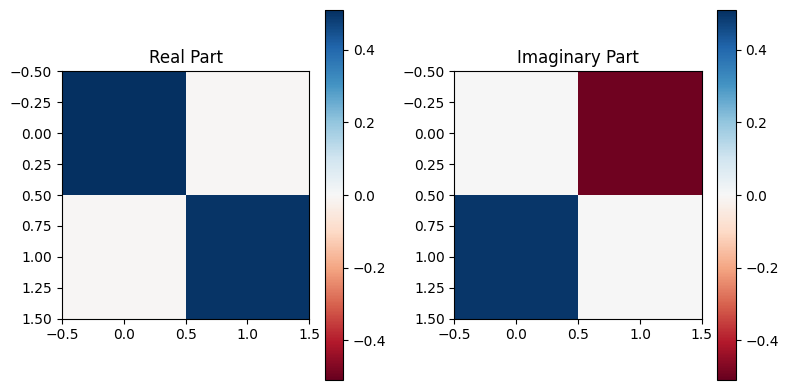

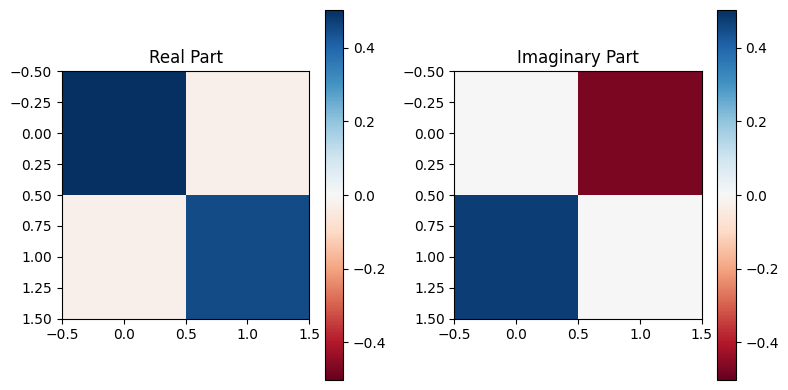

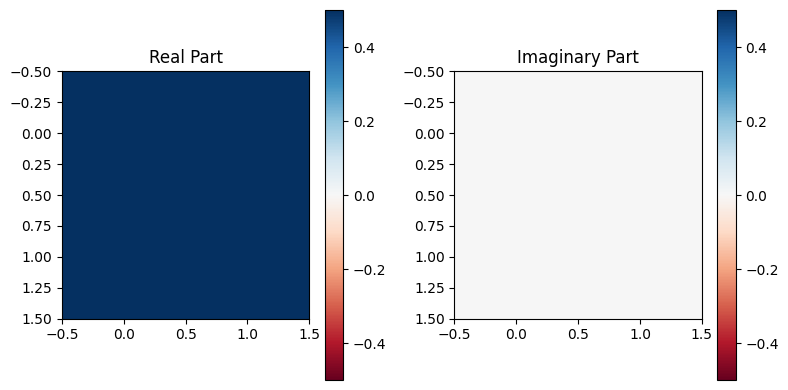

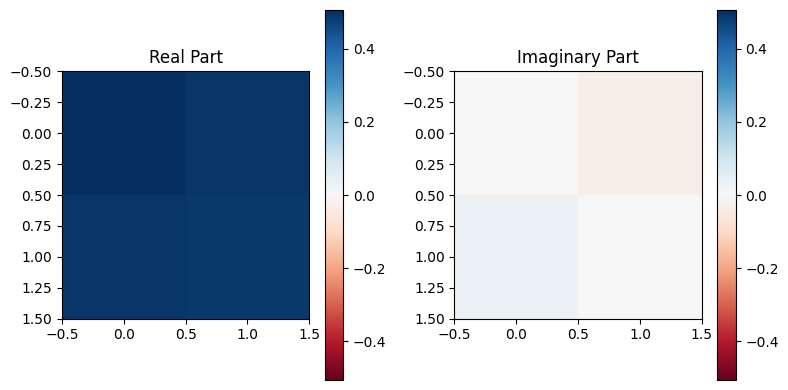

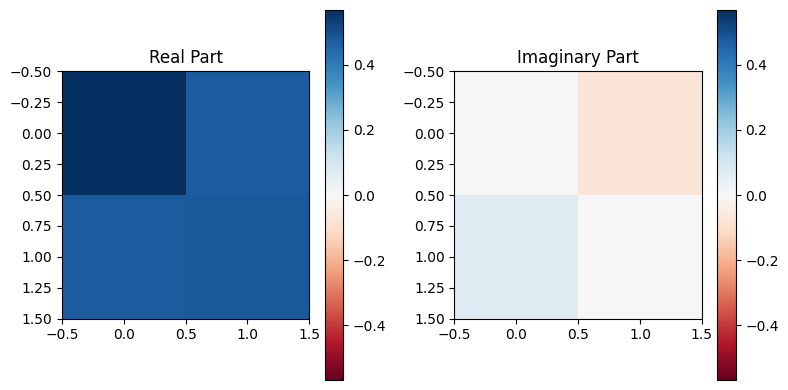

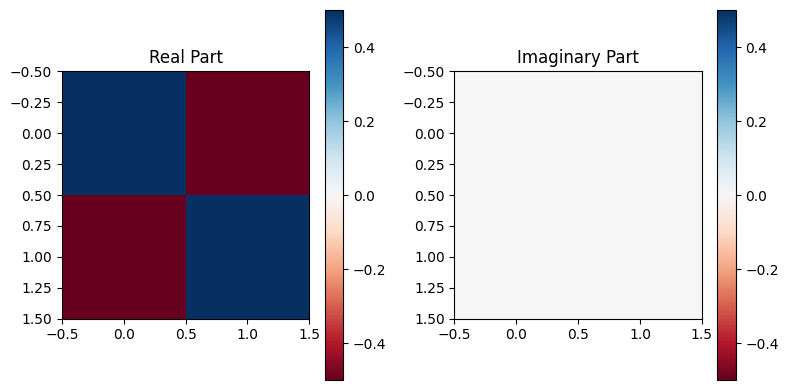

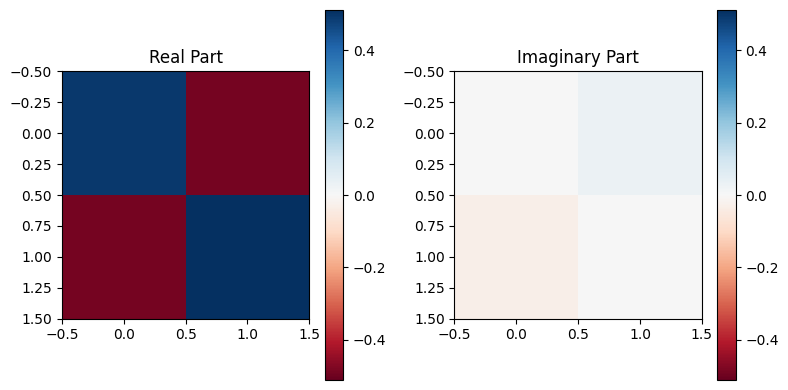

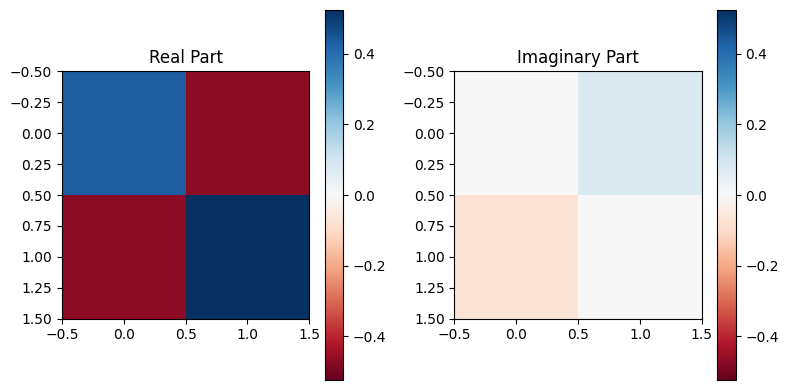

In [213]:
print(QDT_conts_ideal)
print(QDT_conts_ideal/ QDT_conts_lens)
print(QDT_conts_ideal.reshape((6,6)))
ideal_labels = ['V','H','L', 'D', 'R', 'A']
ideal_calibration_states = ph.photon_label_to_operator(ideal_labels)

#exp_povm = ph.coincidence_to_POVM(QDT_conts.reshape((6,6)), traced_down_calib_states, undercomplete=False)
exp_povm_ideal_calib_no_lens = ph.coincidence_to_POVM(QDT_conts_ideal.reshape((6,6)), ideal_calibration_states, undercomplete=False)
exp_povm_ideal_calib_lens = ph.coincidence_to_POVM(QDT_conts_lens.reshape((6,6)), ideal_calibration_states, undercomplete=False)

exp_povm_traced_down_calib_no_lens = ph.coincidence_to_POVM(QDT_conts_ideal.reshape((6,6)), one_qubit_states, undercomplete=False)
exp_povm_traced_down_calib_lens = ph.coincidence_to_POVM(QDT_conts_lens.reshape((6,6)), one_qubit_states, undercomplete=False)


true_op_order_list = [['H','V'], ['L','R'],[ 'D','A']]
true_POVMs = np.array([ph.photon_label_to_operator(true_op_order) for true_op_order in true_op_order_list])
#dist = [sf.POVM_distance(povm.get_POVM(), true_povm) for povm, true_povm in zip(exp_povm,true_POVMs)]
#print(f'Distance between true and expected povm {dist}')
#dist_ideal = [sf.POVM_distance(povm.get_POVM(), true_povm) for povm, true_povm in zip(exp_povm_ideal_calib,true_POVMs)]
#print(f'Distance between true and expected povm {dist_ideal}')
for i in range(len(exp_povm_ideal_calib_no_lens)):
    povm_ideal = exp_povm_traced_down_calib_no_lens[i].get_POVM()
    povm_lens = exp_povm_traced_down_calib_lens[i].get_POVM()
    true = true_POVMs[i]
    vis.visualize_state(true[0])
    vis.visualize_state(povm_ideal[0])
    vis.visualize_state(povm_lens[0])
    vis.visualize_state(true[1])
    vis.visualize_state(povm_ideal[1])
    vis.visualize_state(povm_lens[1])
#print(exp_povm[0].get_POVM())

After having reconstructed the POVM, we want to implement it into the effective experiment.

[21234 23478  5816  8918  8996 21302  6242 25009 23148 22330 20687 42616
  1418 10499 15942  3851]
[[4.  -9.20e-17j 0.99+4.35e-01j 1.01-9.98e-01j 0.48-5.11e-01j]
 [0.99-4.35e-01j 3.98-8.19e-17j 0.01+1.46e-02j 0.99-9.95e-01j]
 [1.01+9.98e-01j 0.01-1.46e-02j 4.  -9.20e-17j 0.99+4.35e-01j]
 [0.48+5.11e-01j 0.99+9.95e-01j 0.99-4.35e-01j 3.98-8.19e-17j]]
[21234 23478  5816  8918  8996 21302  6242 25009 23148 22330 20687 42616
  1418 10499 15942  3851]
[21234 23478 11632 17836  8996 21302  6242 25009 23148 22330 20687 42616
  2836 20998 15942  3851]
[[13.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 13.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j 13.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 13.+0.j]]
[[ 1.30e+01-4.63e-18j  2.35e-15+5.83e-16j  2.79e-17-2.78e-17j
  -2.78e-17-4.47e-17j]
 [ 2.51e-15-4.44e-16j  1.30e+01+1.75e-18j  0.00e+00+3.25e-17j
   8.32e-17+1.67e-16j]
 [-2.79e-17+2.78e-17j  2.78e-17-1.08e-17j  1.30e+01-4.63e-18j
   2.35e-15+5.83e-16j]
 [-2.78e-17-4.77e-18j  2.79e-17-1.67e-16j  2.51e-15-4.

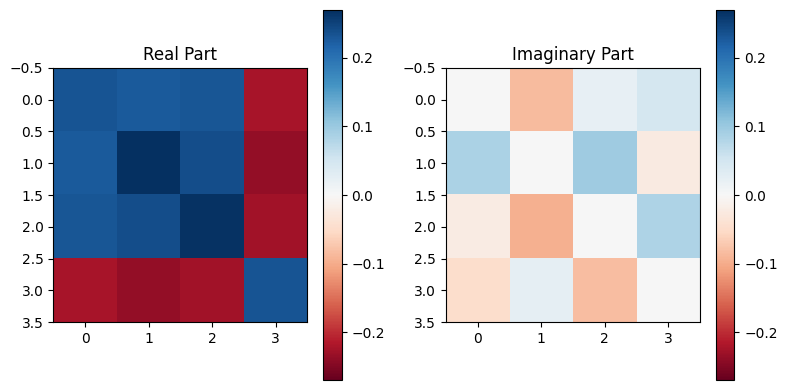

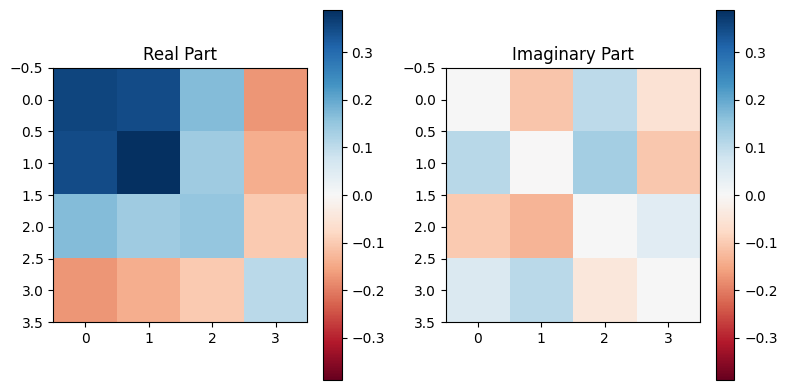

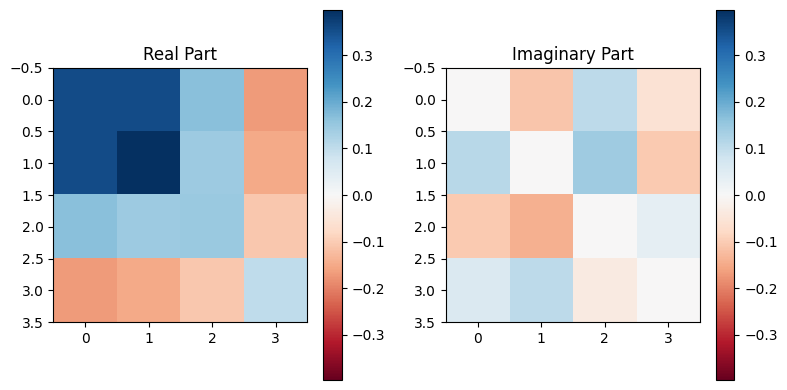

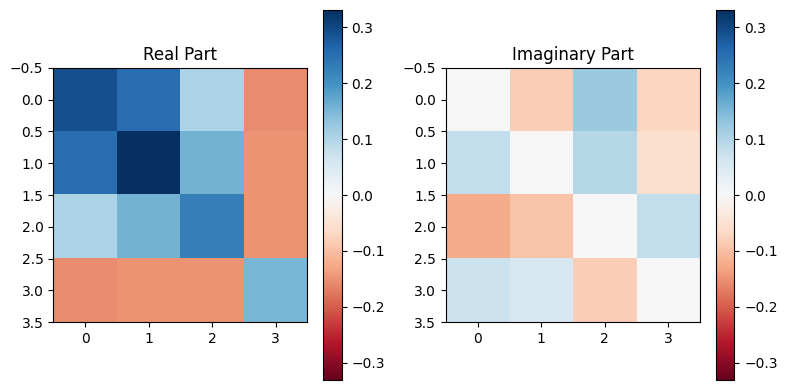

1

In [ ]:
path  = "Photon_REM/photonic QREM experimental data v3/12 HDVA with lens/HDVA_lens.mat"
# paths = glob.glob(path)
# benchmark_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])

benchmark_dict = sp.io.loadmat(path)
no_correction_rho = benchmark_dict['HDVA_lens']
benchmark_coinc_counts = benchmark_dict['HDVA_lens_coincRaw'].T[0]
print(benchmark_coinc_counts)
# Createing the error mitigated operator list

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']

# First operators is perfect, second will be taken from reconstruction. 
#[[H,V],[R,L],[D,A]] 
no_lens_dict = {
    'H': exp_povm_traced_down_calib_no_lens[0].get_POVM()[0],
    'V': exp_povm_traced_down_calib_no_lens[0].get_POVM()[1],
    'L': exp_povm_traced_down_calib_no_lens[1].get_POVM()[0],
    'R': exp_povm_traced_down_calib_no_lens[1].get_POVM()[1],
    'D': exp_povm_traced_down_calib_no_lens[2].get_POVM()[0],
    'A': exp_povm_traced_down_calib_no_lens[2].get_POVM()[1]	
}
exp_povm_ideal_calib_lens
lens_dict = {
    'H' : exp_povm_traced_down_calib_lens[0].get_POVM()[0],
    'V' : exp_povm_traced_down_calib_lens[0].get_POVM()[1],
    'L' : exp_povm_traced_down_calib_lens[1].get_POVM()[0],
    'R' : exp_povm_traced_down_calib_lens[1].get_POVM()[1],
    'D' : exp_povm_traced_down_calib_lens[2].get_POVM()[0],
    'A' : exp_povm_traced_down_calib_lens[2].get_POVM()[1]
    
}
# Create the operator list for 2 qubit QREM
#coincidence_op_list = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], QREM_op_dict[name[1]]) for name in coincidene_order_QST])
coincidence_op_no_lens = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], no_lens_dict[name[1]]) for name in coincidene_order_QST])
#print(coincidence_op_list)
print(np.sum(coincidence_op_no_lens, axis=0))
#QREM_rho = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_list)


mult_vector = np.array([1,1,2,2,1,1,1,1,1,1,1,1,2,2,1,1])
print(benchmark_coinc_counts)
new_coinc = np.einsum('i,i->i',mult_vector, benchmark_coinc_counts)


benchmark_ideal_POVM = ph.coincidence_to_states(new_coinc, QST_op_order)
benchmark_no_lens = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_no_lens)
#print(calib_rhos_exp)
noisy_rho = calib_rhos_exp[2]

true_state = ideal_calib_rho[1]
print(sf.qubit_infidelity(benchmark_no_lens, noisy_rho))
print(sf.qubit_infidelity(no_correction_rho, noisy_rho))
print(sf.qubit_infidelity(benchmark_ideal_POVM, noisy_rho))

#print(f'Comparing accuracy between QREM and no QREM: {sf.qubit_infidelity(QREM_rho, benchmark_ideal_POVM)}')
#print(f'Comparing accuracy between no lense and QREM lense: {sf.qubit_infidelity(benchmark_rho_nolense, QREM_rho)}')
#vis.visualize_state(QREM_rho)
vis.visualize_state(noisy_rho)
vis.visualize_state(benchmark_no_lens)
vis.visualize_state(no_correction_rho)
vis.visualize_state(benchmark_ideal_POVM)
#vis.visualize_state(benchmark_rho_nolense - QREM_rho)




In [207]:
oincRaw'].T[0]
print(benchmark_coinc_counts)
# Createing the error mitigated operator list

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']

# First operators is perfect, second will be taken from reconstruction. 
#[[H,V],[R,L],[D,A]] 
no_lens_dict = {
    'H': exp_povm_ideal_calib_no_lens[0].get_POVM()[0],
    'V': exp_povm_ideal_calib_no_lens[0].get_POVM()[1],
    'L': exp_povm_ideal_calib_no_lens[1].get_POVM()[0],
    'R': exp_povm_ideal_calib_no_lens[1].get_POVM()[1],
    'D': exp_povm_ideal_calib_no_lens[2].get_POVM()[0],
    'A': exp_povm_ideal_calib_no_lens[2].get_POVM()[1]	
}

lens_dict = {
    'H' : exp_povm_traced_down_calib_lens[0].get_POVM()[0],
    'V' : exp_povm_traced_down_calib_lens[0].get_POVM()[1],
    'L' : exp_povm_traced_down_calib_lens[1].get_POVM()[0],
    'R' : exp_povm_traced_down_calib_lens[1].get_POVM()[1],
    'D' : exp_povm_traced_down_calib_lens[2].get_POVM()[0],
    'A' : exp_povm_traced_down_calib_lens[2].get_POVM()[1]
    
}
# Create the operator list for 2 qubit QREM
#coincidence_op_list = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], QREM_op_dict[name[1]]) for name in coincidene_order_QST])
coincidence_op_no_lens = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], no_lens_dict[name[1]]) for name in coincidene_order_QST])
#print(coincidence_op_list)

#QREM_rho = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_list)

benchmark_ideal_POVM = ph.coincidence_to_states(benchmark_coinc_counts, QST_op_order)
benchmark_no_lens = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_no_lens)


#print(f'Comparing accuracy between QREM and no QREM: {sf.qubit_infidelity(QREM_rho, benchmark_ideal_POVM)}')
#print(f'Comparing accuracy between no lense and QREM lense: {sf.qubit_infidelity(benchmark_rho_nolense, QREM_rho)}')
#vis.visualize_state(QREM_rho)
vis.visualize_state(benchmark_no_lens)
vis.visualize_state(no_correction_rho)

#vis.visualize_state(benchmark_rho_nolense - QREM_rho)


SyntaxError: unterminated string literal (detected at line 1) (6860728.py, line 1)

### Simulate photon QREM 

In [12]:

n_QDT_shots = 10**3
n_QST_shots = 10**3
projector_labels = ['H','V','R','D']
projectors = ph.photon_label_to_operator(projector_labels)
# Apply strong depolarizing noise
povm_projectors = POVM(projectors)
depol_POVM = POVM.depolarized_POVM(povm_projectors)
dephasing_POVM = POVM.generate_noisy_POVM(povm_projectors,4)
damped_POVM = POVM.generate_noisy_POVM(povm_projectors,3)


active_POVM = damped_POVM




# Simulate POVM measurements
sim_coincidence = ph.simulate_photon_coincidence_counts(n_QDT_shots, one_qubit_states, active_POVM.get_POVM())
sim_povm_recon = ph.coincidence_to_POVM(sim_coincidence, one_qubit_states)

# Simulate QST measurements
sim_rho_true = sf.generate_random_Hilbert_Schmidt_mixed_state(1)
QST_sim_coinc = ph.simulate_photon_coincidence_counts(n_QST_shots, [sim_rho_true], active_POVM.get_POVM())


QREM_op_dict = {
    'H': sim_povm_recon[0].get_POVM()[0],
    'V': sim_povm_recon[0].get_POVM()[1],
    'L': sim_povm_recon[1].get_POVM()[0],
    'R': sim_povm_recon[1].get_POVM()[1],
    'D': sim_povm_recon[2].get_POVM()[0],
    'A': sim_povm_recon[2].get_POVM()[1]	
}
sim_op_recon_list = np.array([QREM_op_dict[label] for label in projector_labels])

print(f'POVM recon accuracy: {sf.POVM_distance(sim_op_recon_list, active_POVM.get_POVM())}')

sim_rho_recon = ph.coincidence_to_states(QST_sim_coinc, sim_op_recon_list, n_qubits=1)

print(f'Simulated reconstruction accuracy: {sf.qubit_infidelity(sim_rho_recon, sim_rho_true)}')


	Number of MLE iterations: 300, final distance 1.6755133391832544e-10
	Number of MLE iterations: 150, final distance 3.6032288264209456e-13
	Number of MLE iterations: 700, final distance 3.4045517793845903e-10
POVM recon accuracy: 0.001411015427134267
Simulated reconstruction accuracy: 6.852644858224011e-07


Highlight issues:

Benchmark data ratio no lense/lense: [3.04562227 2.97400347 2.48852562 2.99789584 0.53831776 3.25491503
 1.97581362 5.34266985 3.39540385 3.24262462 5.86273115 3.25711275
 2.80928127 1.90410959 2.23022056 2.10591372]
Benchmark coincs: 
[[ 9079. 12012.  7916. 11398.   576. 19536. 11110.  8965. 10047. 19125.
   8243.  9273.  9928.   139. 20324.  8689.]
 [ 2981.  4039.  3181.  3802.  1070.  6002.  5623.  1678.  2959.  5898.
   1406.  2847.  3534.    73.  9113.  4126.]]
Problematic measurement is RH.
QDT coincs: 
[  201. 12256.  5298.  3492.  7957.   233.  3902.  5253.  4361.  5083.
   164.  6145.  1598.  8417. 10223.  5570.  4895.  4330.  6694.  3271.
  6747.  2216.  1144.  3707.]
Problematic is D state with R meaurement: 10223.0
and L state with R measurement: 6694.0
0.5160602124932168 0.5947964923728037
0.5160602124932168 0.5764432081434694
0.5160602124932168 0.4105599031643852
0.45192638853914224 0.5947964923728037
0.45192638853914224 0.5764432081434694
0.45192638853914224 0.4105599031

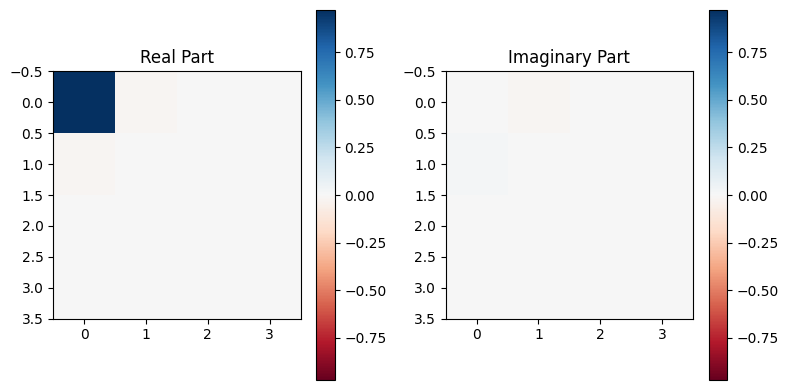

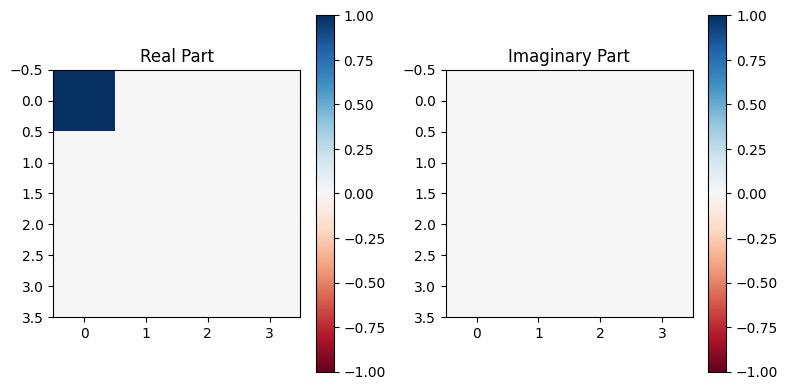

Opeators for HV


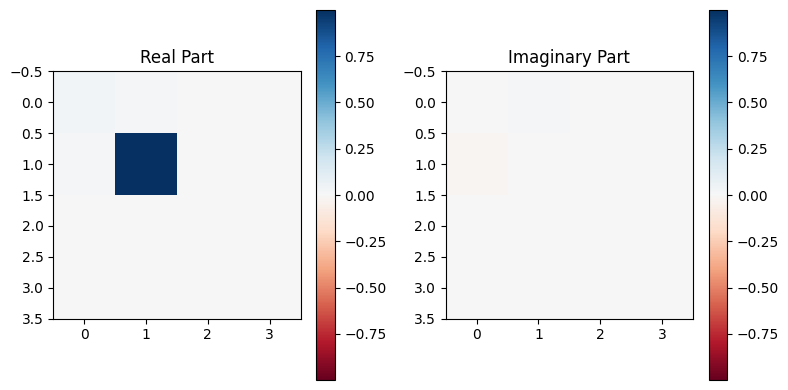

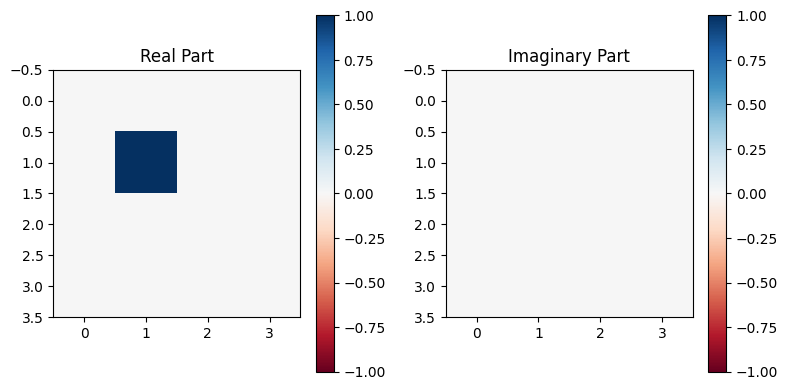

Opeators for VV


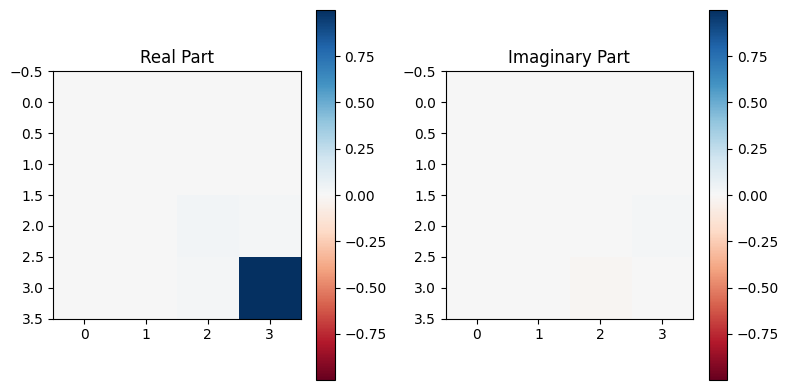

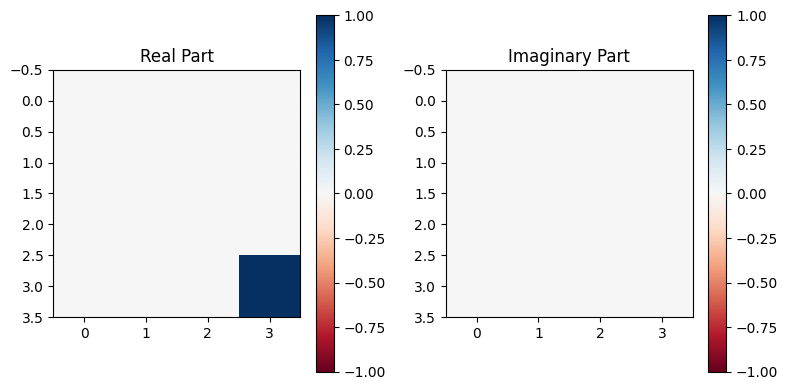

Opeators for VH


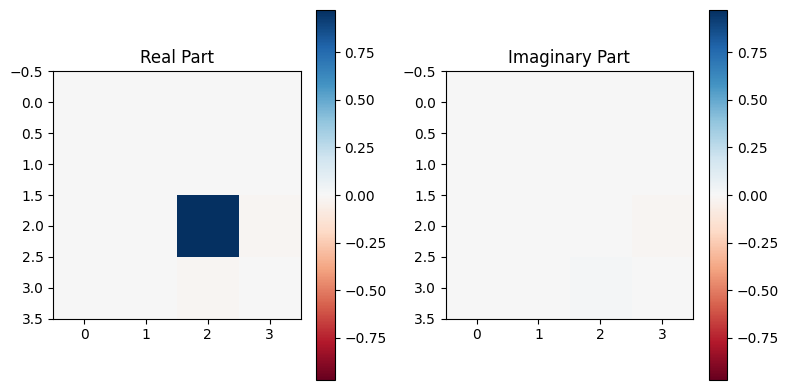

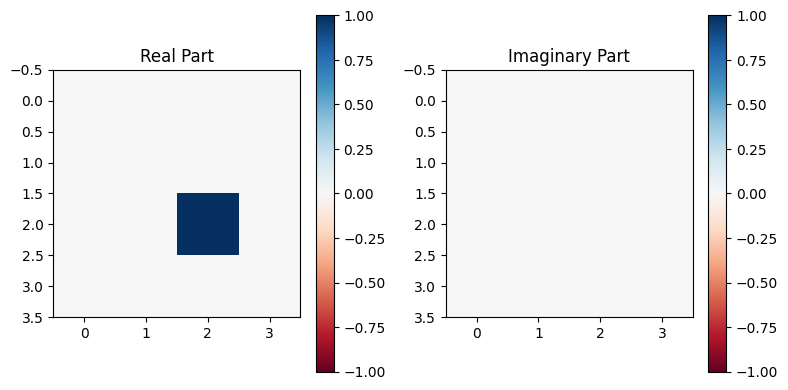

Opeators for RH


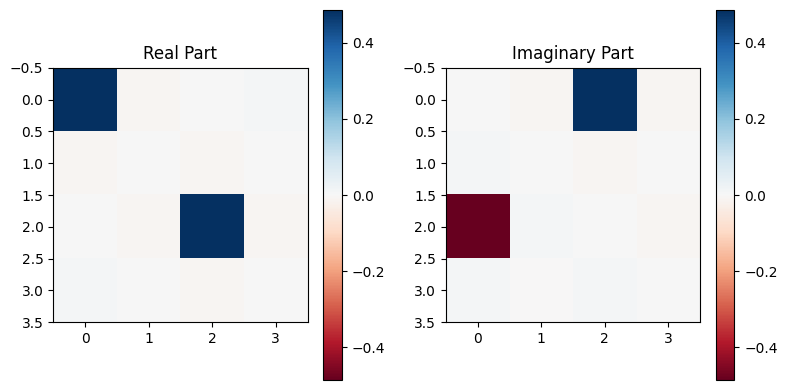

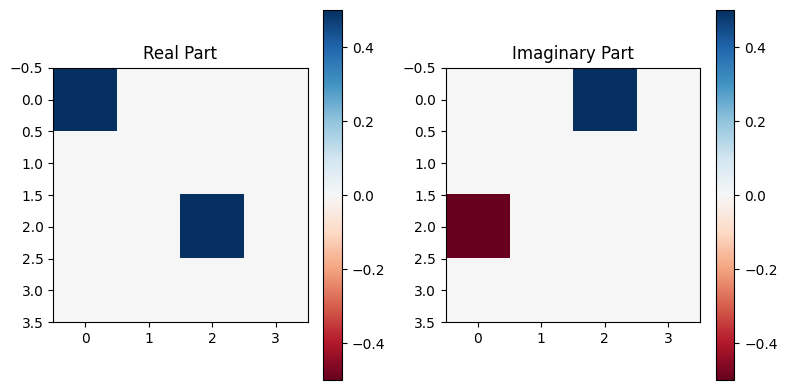

Opeators for RV


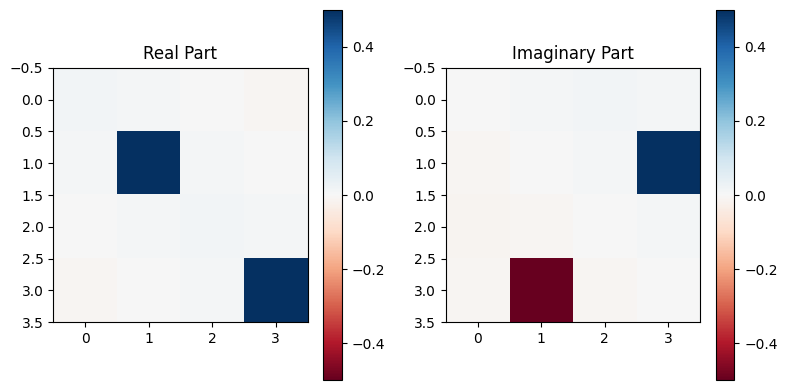

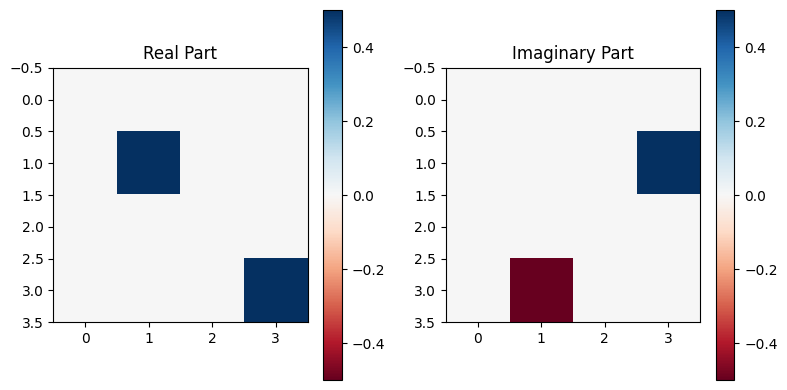

Opeators for DV


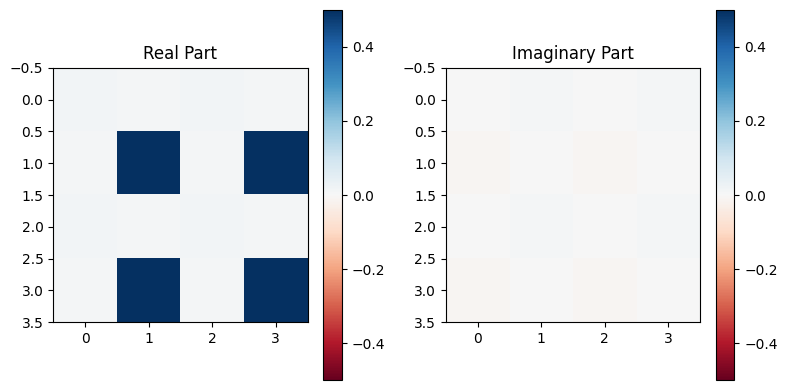

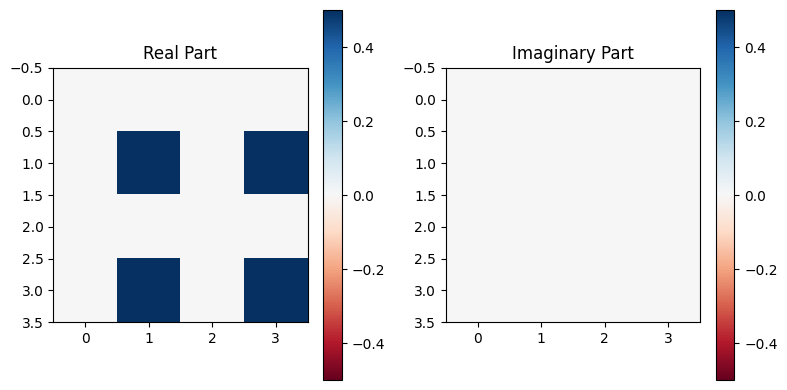

Opeators for DH


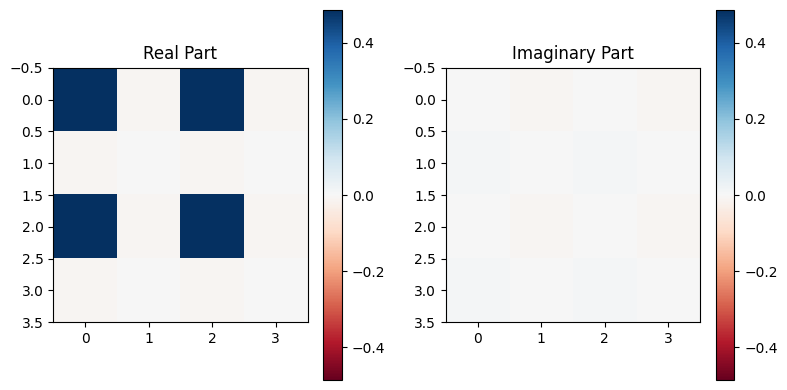

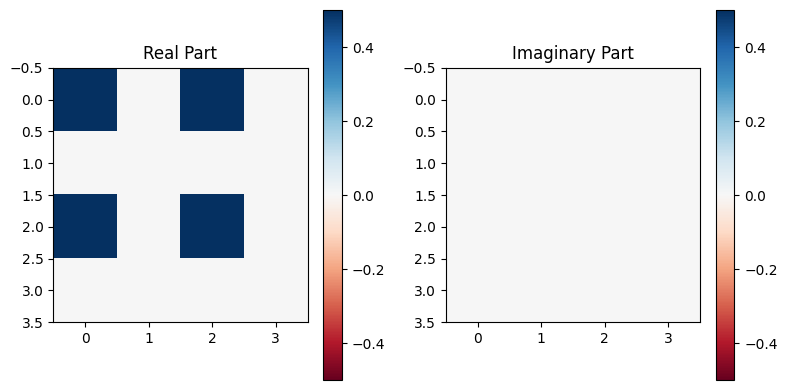

Opeators for DR


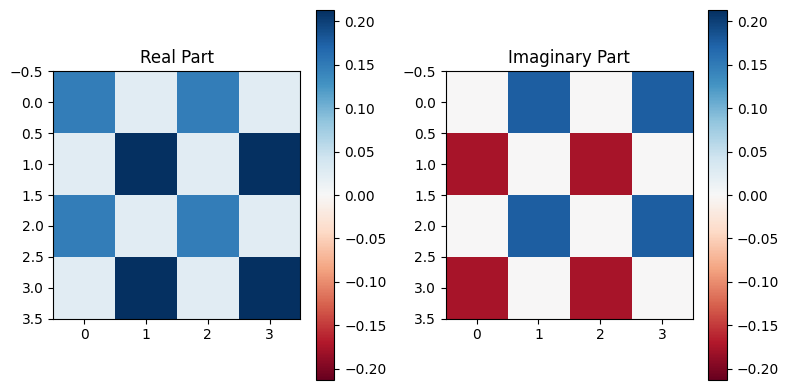

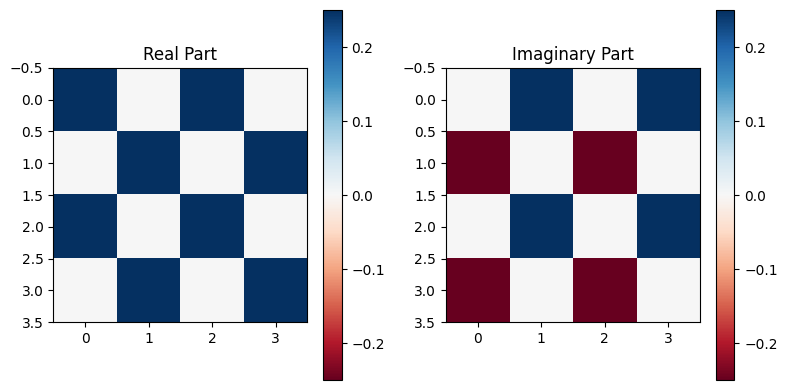

Opeators for DD


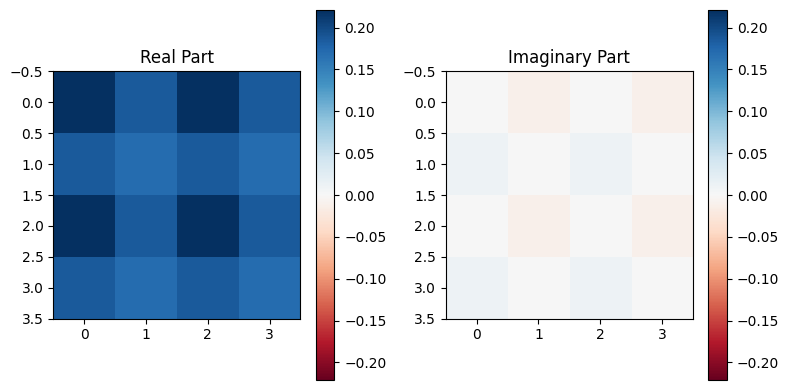

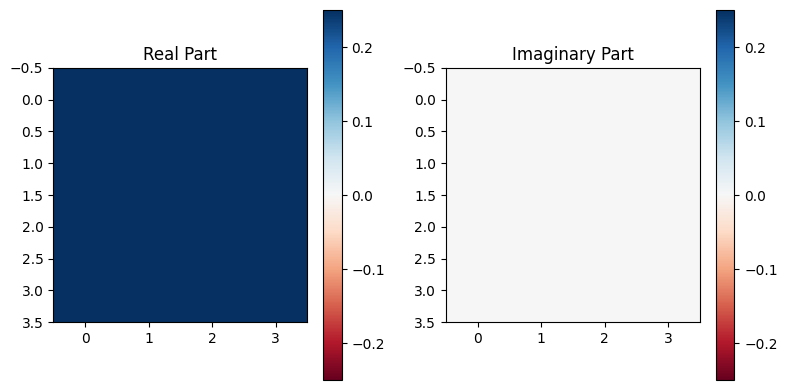

Opeators for RD


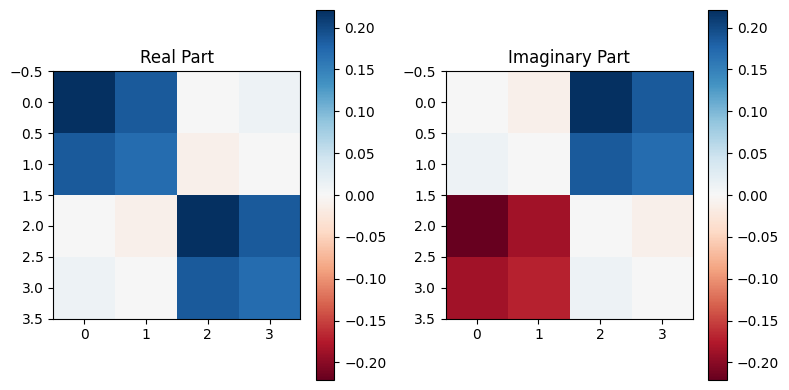

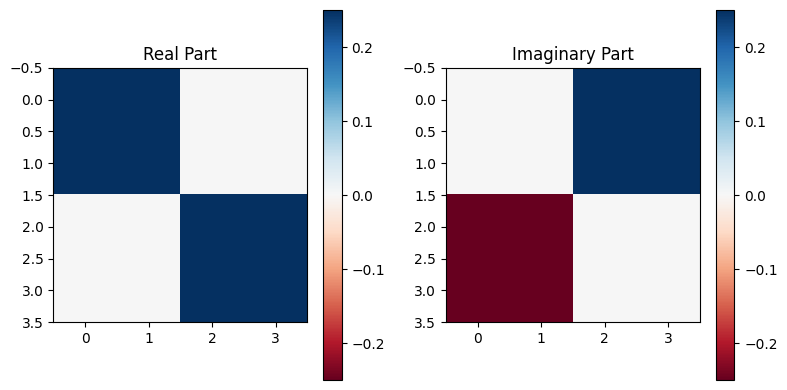

Opeators for HD


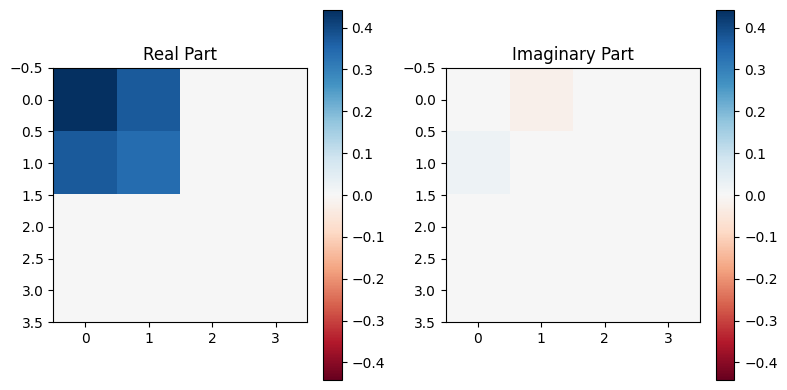

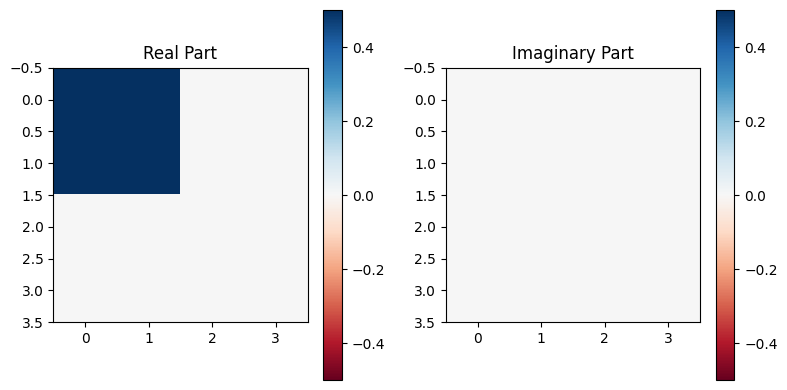

Opeators for VD


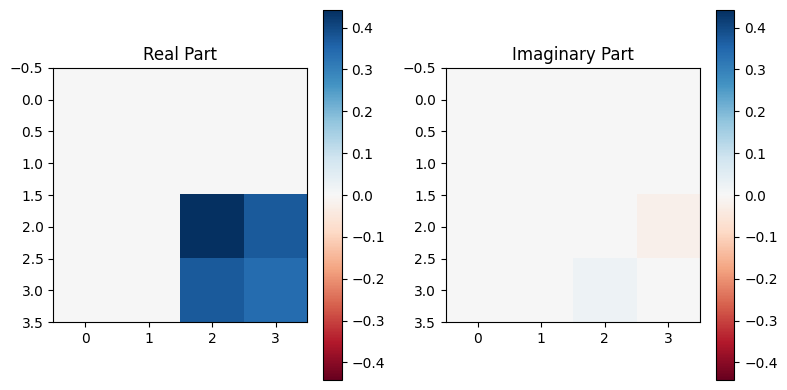

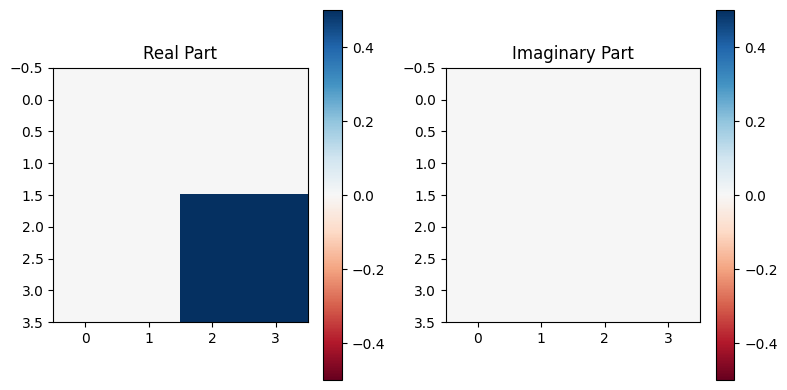

Opeators for VL


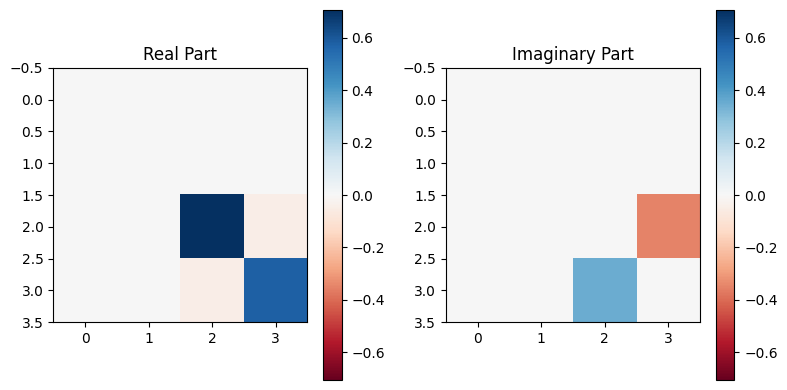

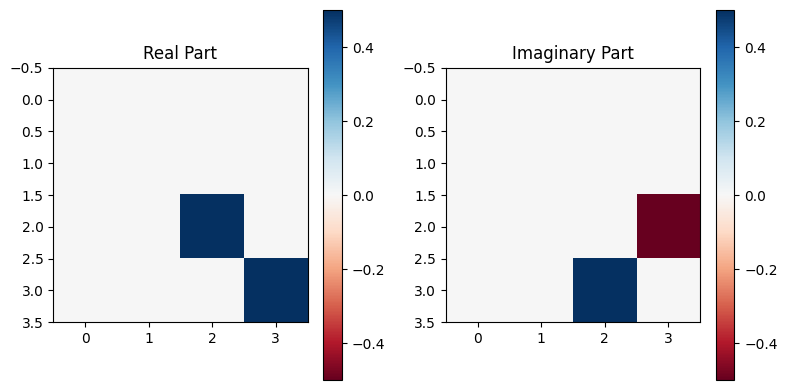

Opeators for HL


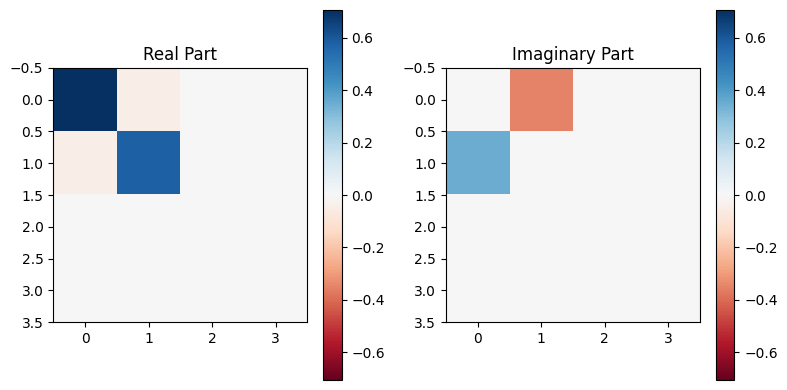

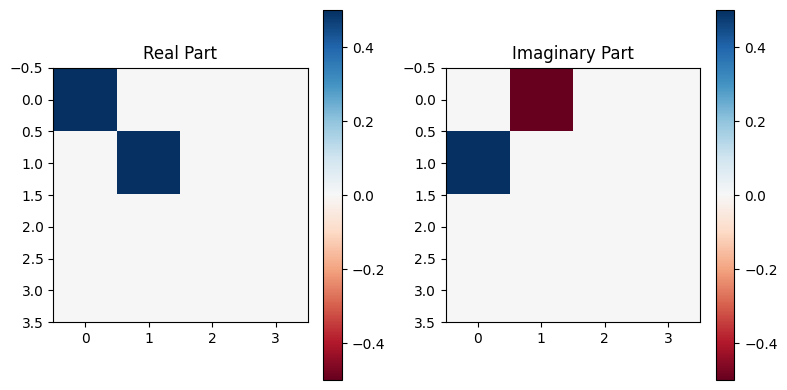

Opeators for RL


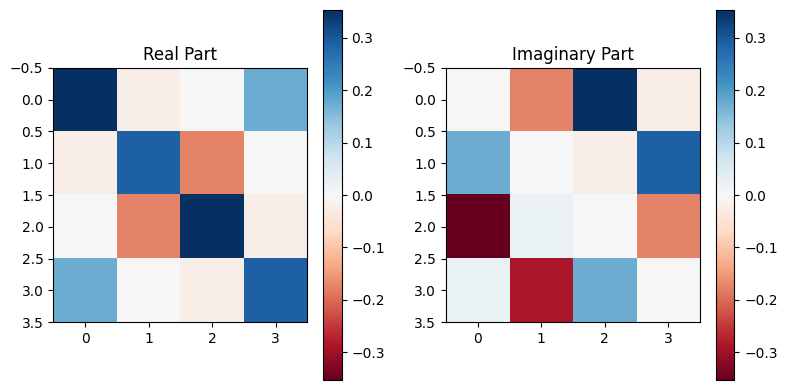

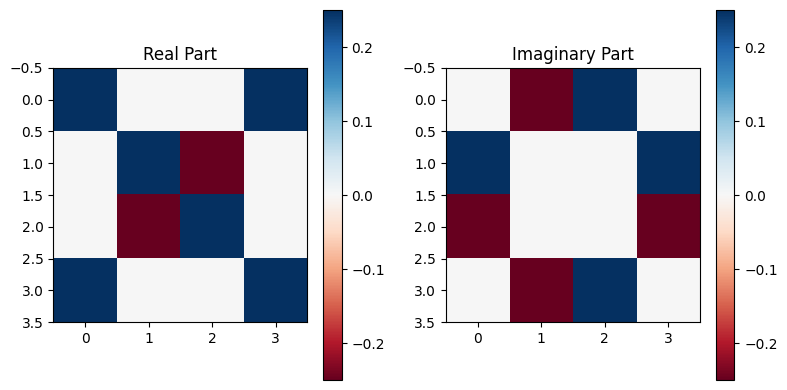

In [13]:
# Benchmark data issue/variability
benchmark_rations = benchmark_coinc_counts[0]/benchmark_coinc_counts[1]
print(f'Benchmark data ratio no lense/lense: {benchmark_rations}')
print(f'Benchmark coincs: \n{benchmark_coinc_counts}')
print(f'Problematic measurement is RH.')


# QDT data issue/variability

print(f'QDT coincs: \n{QDT_conts}')

print(f'Problematic is D state with R meaurement: {QDT_conts[14]}')
print(f'and L state with R measurement: {QDT_conts[-6]}')

temp_rho = sf.generate_random_Hilbert_Schmidt_mixed_state(2)
povm = POVM.generate_Pauli_POVM(2)
for pv in povm:
    hist = pv.get_histogram(temp_rho)
    n_tot = hist[0] + hist[1]
    n_tot2 = hist[0] + hist[2]
    print(n_tot,n_tot2)

for i in range(len(coincidence_op_list)):
    print(f'Opeators for {coincidene_order_QST[i]}')
    vis.visualize_state(coincidence_op_list[i])
    vis.visualize_state(QST_op_order[i])